In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('../dataset/names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0

itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

def build_dataset(words):
    block_size = 3 # context length
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])

            context = context[1:] + [ix] # crop the first latter and append the one ahead
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X, Y


import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])


In [5]:
Xtr.shape, Xdev.shape, Xtest.shape

(torch.Size([182625, 3]), torch.Size([22655, 3]), torch.Size([22866, 3]))

In [135]:
g = torch.Generator().manual_seed(2147483647) # To generate same random numbers everytime
vocab_size = 27
n_embd = 10
block_size = 3
n_hidden = 200

C = torch.randn((vocab_size, n_embd), generator=g)

W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden, generator=g) * 0.01

W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]

for p in parameters:
    p.requires_grad = True

sum(p.nelement() for p in parameters)

12297

In [136]:
lri = []
lossi = []
stepi = []

In [137]:
# Iterations...
for i in range(200000):
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # Forward Pass
    emb = C[Xtr[ix]] # shape = (32, 3, 10)
    hpreact = emb.view(emb.shape[0], 30) @ W1 + b1

    # Implement Batch Norm
    hpreact_mean = hpreact.mean(0, keepdim=True)
    hpreact_std = hpreact.std(0, keepdim=True)
    hpreact  = bngain * (hpreact - hpreact_mean) / hpreact_std + bnbias

    hidden_layer = torch.tanh(hpreact) # shape = (32, 200)
    logits = hidden_layer @ W2 + b2 # shape = (32, 27)

    loss = F.cross_entropy(logits, Ytr[ix])
    print("Loss: ", loss.item())

    # Backward Pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # Update
    lr = 0.01 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    stepi.append(i)
    lossi.append(loss.log10().item())

Loss:  3.3020148277282715
Loss:  3.3168749809265137
Loss:  3.297887086868286
Loss:  3.296675205230713
Loss:  3.294241189956665
Loss:  3.2523081302642822
Loss:  3.2668538093566895
Loss:  3.288100242614746
Loss:  3.2420055866241455
Loss:  3.28159499168396
Loss:  3.2506332397460938
Loss:  3.283635377883911
Loss:  3.2590882778167725
Loss:  3.2576701641082764
Loss:  3.2881314754486084
Loss:  3.2545318603515625
Loss:  3.2563629150390625
Loss:  3.239480495452881
Loss:  3.268838405609131
Loss:  3.2480413913726807
Loss:  3.2852976322174072
Loss:  3.2357242107391357
Loss:  3.2348201274871826
Loss:  3.2259180545806885
Loss:  3.2837677001953125
Loss:  3.226515531539917
Loss:  3.2607839107513428
Loss:  3.2534444332122803
Loss:  3.230247735977173
Loss:  3.2487354278564453
Loss:  3.27673602104187
Loss:  3.1935267448425293
Loss:  3.1601810455322266
Loss:  3.197364091873169
Loss:  3.176694393157959
Loss:  3.2107744216918945
Loss:  3.233751058578491
Loss:  3.180811643600464
Loss:  3.169187307357788
Loss

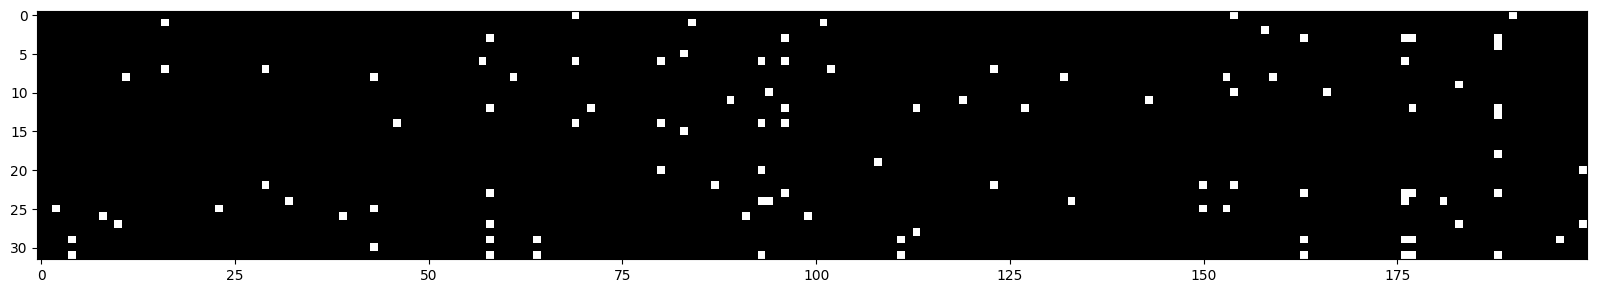

In [119]:
#plt.hist(hidden_layer.view(-1).tolist(), 50)
plt.figure(figsize=(20,10))
plt.imshow(hidden_layer.abs() > 0.99, cmap = 'gray', interpolation='nearest')

200000

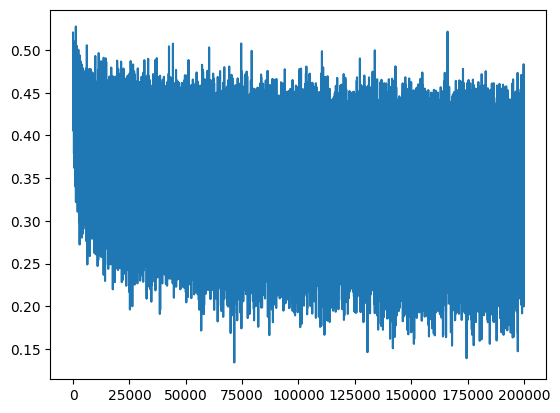

In [139]:
plt.plot(stepi, lossi)
len(lossi)

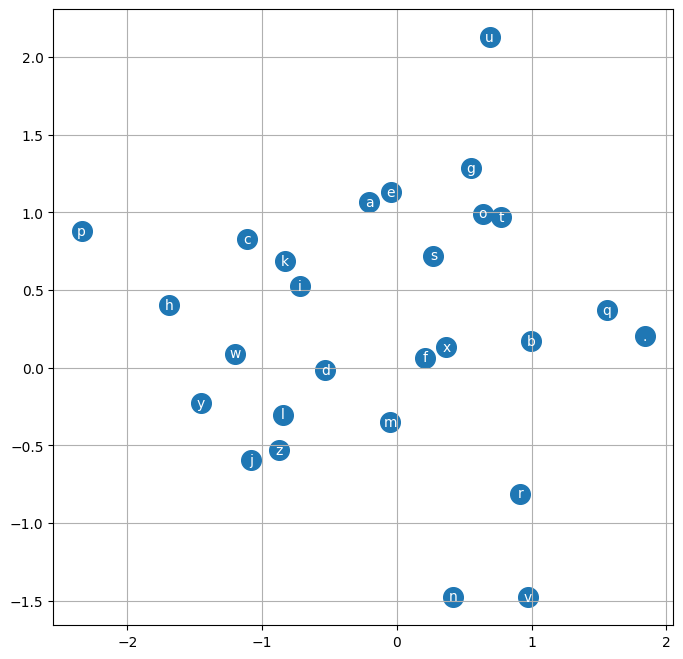

In [140]:
# Visualizing our 2d embeddings
plt.figure(figsize=(8,8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)

for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')

plt.grid('minor')

In [141]:
# Evaluating dev loss
emb = C[Xdev] # shape = (len(Xdev[0]), 3, 2)
hpreact = emb.view(emb.shape[0], 30) @ W1 + b1
        
# Implement Batch Norm
hpreact_mean = hpreact.mean(0, keepdim=True)
hpreact_std = hpreact.std(0, keepdim=True)
hpreact  = bngain * (hpreact - hpreact_mean) / hpreact_std + bnbias

hidden_layer = torch.tanh(hpreact) # shape = (len(Xdev[0]), 100)
logits = hidden_layer @ W2 + b2 # shape = (len(Xdev[0]), 27)

loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1404, grad_fn=<NllLossBackward0>)

In [148]:
# Evaluating test loss
emb = C[Xtest] # shape = (len(Xtest[0]), 3, 2)
hpreact = emb.view(emb.shape[0], 30) @ W1 + b1
        
# Implement Batch Norm
hpreact_mean = hpreact.mean(0, keepdim=True)
hpreact_std = hpreact.std(0, keepdim=True)
hpreact  = bngain * (hpreact - hpreact_mean) / hpreact_std + bnbias

hidden_layer = torch.tanh(hpreact) # shape = (len(Xdev[0]), 100)
logits = hidden_layer @ W2 + b2 # shape = (len(Xdev[0]), 27)

loss = F.cross_entropy(logits, Ytest)
loss

tensor(2.1413, grad_fn=<NllLossBackward0>)

In [153]:
# Sampling words

result = []
block_size = 3

for _ in range(20):
    block = [0] * block_size
    pred_word = []
    while True:
        Xt = torch.tensor([block])

        # Forward Pass
        embed = C[Xt] # shape = (1, 3, 2)
        hpreact = embed.view(embed.shape[0], 30) @ W1 + b1
        
        # # Implement Batch Norm
        hpreact_mean = hpreact.mean()
        hpreact_std = hpreact.std()
        hpreact  = bngain * (hpreact - hpreact_mean) / hpreact_std + bnbias

        hidden_layer = torch.tanh(hpreact) # shape = (32, 100)
        
        logits = hidden_layer @ W2 + b2 # shape = (32, 27)

        counts = torch.exp(logits)
        prob = counts / counts.sum(1, keepdims=True)

        pred_target = torch.multinomial(prob, num_samples=1, replacement=True, generator=g)
        pred_character = itos[pred_target.item()]
        # print(pred_character)

        if pred_character == '.':
            break

        pred_word.append(pred_character)
        block = block[1:] + [pred_target.item()]

    result.append(''.join(pred_word))

result

['markshrihd',
 'bat',
 'janan',
 'vie',
 'ardghrandri',
 'abderlesh',
 'xarden',
 'kaib',
 'mal',
 'annab',
 'emrizabyna',
 'surraceljandre',
 'jamridagjya',
 'jeamina',
 'alen',
 'zher',
 'dadhfingarm',
 'brzaly',
 'amalle',
 'shapsea']